# Вариационный автокодировщик

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Генерация данных

In [2]:
import sklearn.datasets

# 2D набор данных
data = sklearn.datasets.make_moons(n_samples=1000, noise=0.1)[0]
X = data.astype("float32")

In [3]:
X[:5]

array([[ 0.00422392,  1.0899847 ],
       [ 0.3466738 ,  0.85424876],
       [-0.93382484,  0.5109497 ],
       [ 0.37608802, -0.5341812 ],
       [-0.5737063 ,  0.7411401 ]], dtype=float32)

## Визуалиация данных

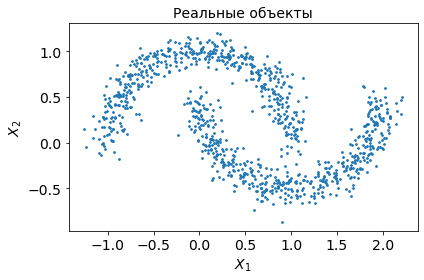

In [4]:
plt.figure(figsize=(6, 4))
plt.scatter(X[:, 0], X[:, 1], s=3, color='C0')
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlabel(r'$X_1$', size=14)
plt.ylabel(r'$X_2$', size=14)
plt.title('Реальные объекты', size=14)
plt.tight_layout()
plt.show()

## Кодировщик

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
DEVICE

device(type='cpu')

In [7]:
class Encoder(nn.Module):
    def __init__(self, n_inputs, lat_size):
        super(Encoder, self).__init__()
        
        self.enc_net = nn.Sequential( 
                                nn.Linear(n_inputs, 100), 
                                nn.BatchNorm1d(100),
                                nn.ReLU(),
                                nn.Linear(100, 100),
                                nn.BatchNorm1d(100),
                                nn.ReLU())
        
        self.mu = nn.Linear(100, lat_size)
        self.log_sigma = nn.Linear(100, lat_size)
        
    def forward(self, x):
        z = self.enc_net(x)
        mu = self.mu(z)
        log_sigma = self.log_sigma(z)
        return mu, log_sigma

## Декодировщик

In [8]:
class Decoder(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(Decoder, self).__init__()
        
        self.dec_net = nn.Sequential(
                                    nn.Linear(n_inputs, 100), 
                                    nn.ReLU(),
                                    nn.Linear(100, 100),
                                    nn.ReLU(),
                                    nn.Linear(100, n_outputs))
        
    def forward(self, z):
        x_rec = self.dec_net(z)
        return x_rec

## Обучение

In [9]:
class VAEFitter(object):
    
    def __init__(self, encoder, decoder, batch_size=32, n_epochs=10, latent_dim=1, lr=0.0001, KL_weight=0.001):
        
        self.encoder = encoder
        self.decoder = decoder
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.KL_weight = KL_weight
        
        self.criterion = nn.MSELoss()
        self.opt  = torch.optim.RMSprop(list(self.encoder.parameters()) + list(self.decoder.parameters()), 
                                        lr=self.lr)
        
        self.encoder.to(DEVICE)
        self.decoder.to(DEVICE)
        
        
    def sample_z(self, mu, log_sigma):
        eps = torch.randn(mu.shape).to(DEVICE)
        return mu + torch.exp(log_sigma / 2) * eps
    
    
    def vae_loss(self, x, rec_x, mu, log_sigma):
        recon_loss = self.criterion(x, rec_x)
        KL = torch.mean(-0.5 * torch.sum(1 + log_sigma - mu**2 - log_sigma.exp(), dim = 1), dim = 0)
        return recon_loss + KL * self.KL_weight
    
    
    def compute_loss(self, x_batch):
        # кодируем x -> z
        mu, log_sigma = self.encoder(x_batch)
        
        # декодируем z' -> x_reco
        z_batch = self.sample_z(mu, log_sigma)
        x_batch_rec = self.decoder(z_batch)
        
        # считаем значение функции потерь
        loss = self.vae_loss(x_batch, x_batch_rec, mu, log_sigma)
        return loss
    
    
    def fit(self, X):
        
        # переводим данные в тензор
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        # tensor to dataset
        dataset_real = TensorDataset(X_real)
        
        # включаем режим обучения
        self.encoder.train(True)
        self.decoder.train(True)
        
        self.loss_history = []

        # цикл обучения
        for epoch in range(self.n_epochs):
            for (x_batch, ) in DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True):
                
                # вычисляем значение функции потерь
                loss = self.compute_loss(x_batch)
                
                # делаем шаг оптимизации
                self.opt.zero_grad()
                loss.backward()
                self.opt.step()
                    
                # сохраняем значение функции потерь
                self.loss_history.append(loss.detach().cpu())
                    
        # выключаем режим обучения
        self.encoder.train(False)
        self.decoder.train(False)

Теперь обучим вариационный автокодировщик на наших данных

In [10]:
%%time

latent_dim = 2

encoder = Encoder(n_inputs=X.shape[1], lat_size=latent_dim)
decoder = Decoder(n_inputs=latent_dim, n_outputs=X.shape[1])

vae_fitter = VAEFitter(encoder, decoder, 
                       batch_size=64, n_epochs=1000, latent_dim=latent_dim, 
                       lr=0.001, KL_weight=0.001)
vae_fitter.fit(X)

CPU times: user 1min 11s, sys: 3.01 s, total: 1min 14s
Wall time: 1min 7s


Построим кривую обучения

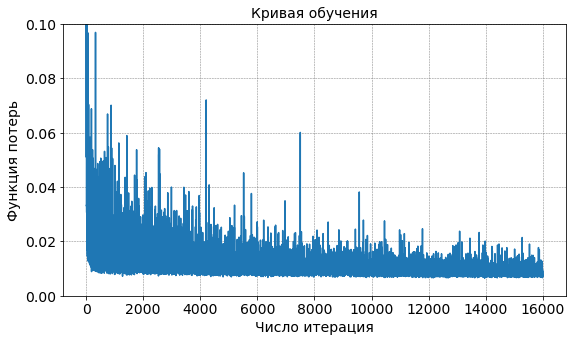

In [11]:
plt.figure(figsize=(9, 5))
plt.plot(vae_fitter.loss_history)
plt.xlabel("Число итерация", size=14)
plt.ylabel("Функция потерь", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Кривая обучения", size=14)
plt.grid(b=1, linestyle='--', linewidth=0.5, color='0.5')
plt.ylim(0, 0.1)
plt.show()

## Генерация новых объектов

Генерируем шум в скрытом пространстве

In [12]:
N = 10000
Z = torch.normal(0, 1, (N, latent_dim))

С помощью декодировщика переводим шум в новые объекты

In [13]:
X_fake = decoder(Z).cpu().detach().numpy()

## Визуализация новых объектов

In [14]:
Z = Z.cpu().detach().numpy()

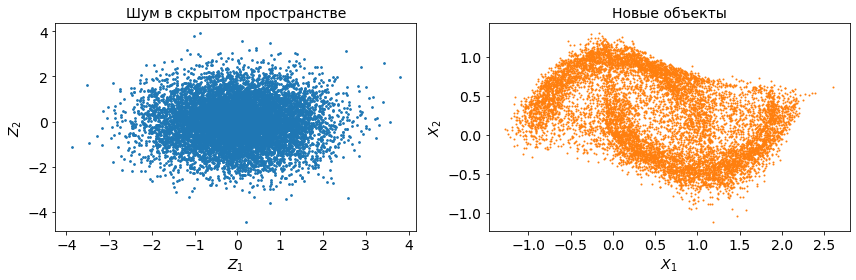

In [15]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.scatter(Z[:, 0], Z[:, 1], s=3, color='C0')
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlabel(r'$Z_1$', size=14)
plt.ylabel(r'$Z_2$', size=14)
plt.title('Шум в скрытом пространстве', size=14)

plt.subplot(1, 2, 2)
plt.scatter(X_fake[:, 0], X_fake[:, 1], s=1, color='C1')
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlabel(r'$X_1$', size=14)
plt.ylabel(r'$X_2$', size=14)
plt.title('Новые объекты', size=14)
plt.tight_layout()
plt.show()